# Google Timeseries Prediction

We will predict stock prices for Google using a timeseries data.

## 0. Importing Libraries

In [36]:
# uncomment the following line to install the libraries
# !pip install numpy pandas matplotlib seaborn torch scikit-learn xgboost joblib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy as dc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBClassifier

from joblib import dump

## 1. Data and Some EDA 

#### **Device**

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

#### **Loading the Data:**

In [4]:
data = pd.read_csv('GOOG.csv', index_col=False)
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [5]:
data.Date = pd.to_datetime(data.Date)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512


#### **Statisctics**:

In [6]:
data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,4858,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4.858000e+03
mean,2014-04-12 02:30:17.044051200,41.477174,41.917059,41.055491,41.494404,41.494404,1.189152e+08
min,2004-08-19 00:00:00,2.470490,2.534002,2.390042,2.490913,2.490913,1.584340e+05
25%,2009-06-16 06:00:00,12.846597,12.954195,12.712414,12.834642,12.834642,2.854912e+07
50%,2014-04-12 12:00:00,26.499958,26.728268,26.289323,26.537501,26.537501,6.168836e+07
75%,2019-02-07 18:00:00,57.367250,58.028500,56.962251,57.611249,57.611249,1.467329e+08
max,2023-12-05 00:00:00,151.863495,152.100006,149.887497,150.709000,150.709000,1.650833e+09
std,NaN,38.590695,39.031758,38.193016,38.618107,38.618107,1.512424e+08


#### **Null values and duplicates**

In [7]:
print(f'Number of null values per each column:\n{data.isna().sum()}')

Number of null values per each column:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [8]:
print(f'Number of null values per each column: {data.duplicated().sum()}')

Number of null values per each column: 0


#### **Timeseries**

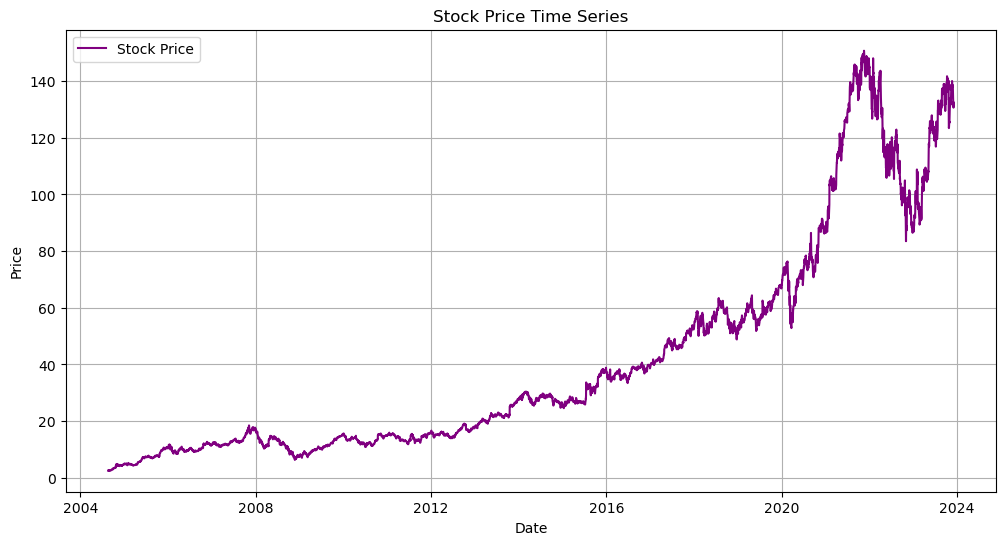

In [9]:
plt.figure(figsize=[12, 6])
plt.plot(data['Date'], data['Close'], label='Stock Price', color='purple')
plt.title('Stock Price Time Series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

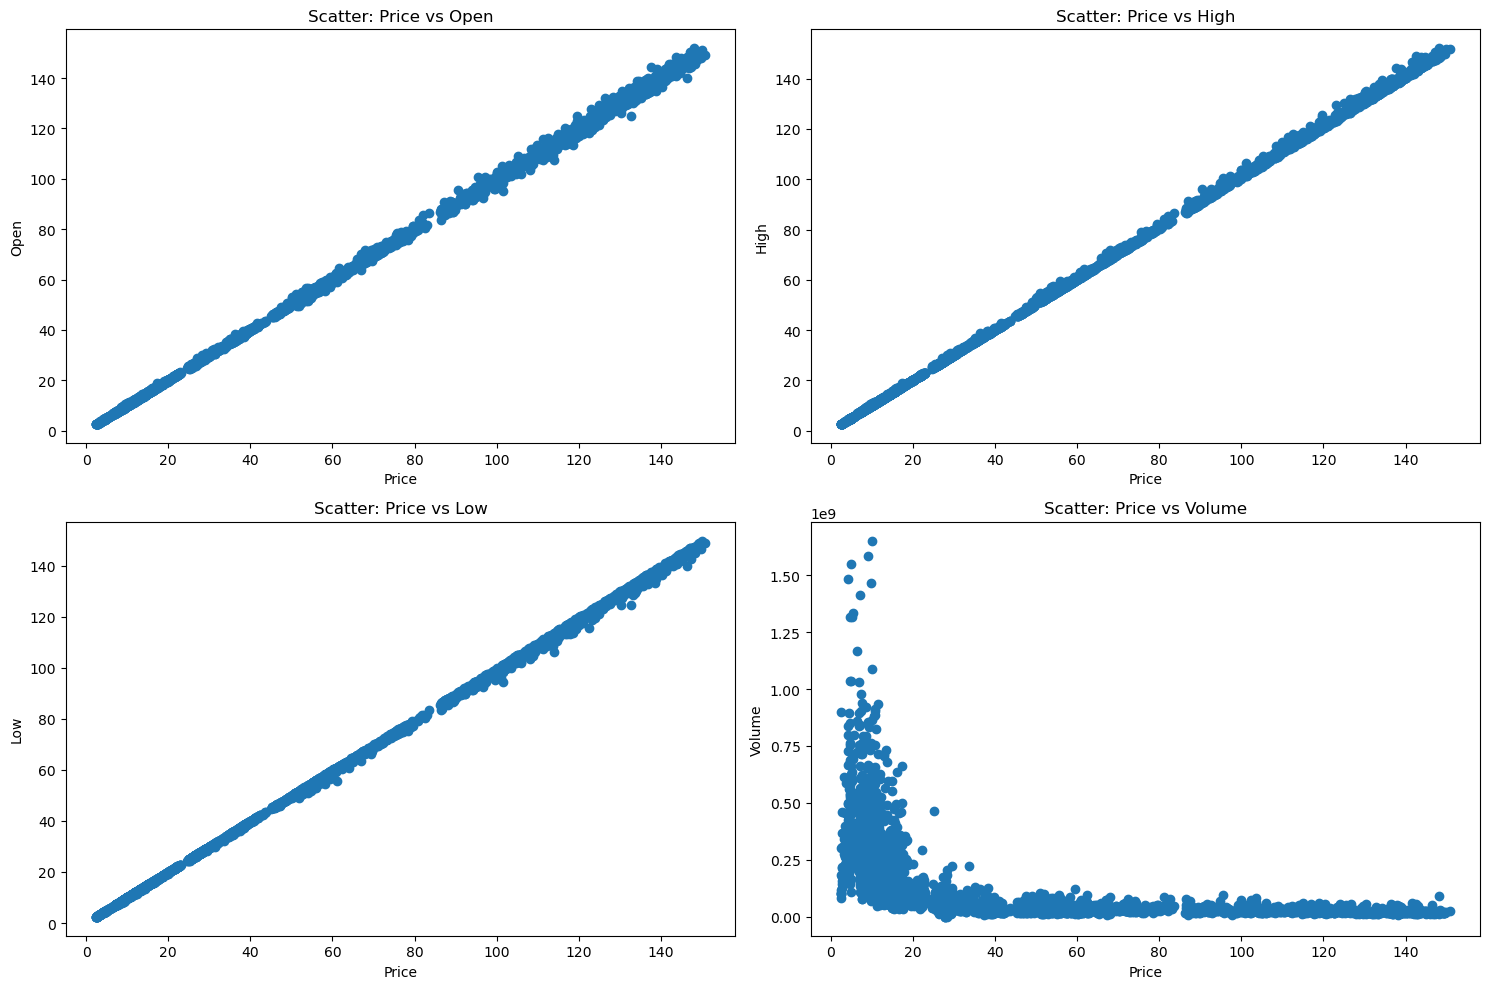

In [10]:
columns = [col for col in data.columns if col not in ['Date', 'Close', 'Adj Close']]

fig, axs = plt.subplots(nrows=len(columns) // 2, ncols=2, figsize=(15, 5*(len(columns)//2)))

for idx, col in enumerate(columns):
	row = idx // 2
	col_idx = idx % 2
	axs[row, col_idx].scatter(data['Close'], data[col])
	axs[row, col_idx].set_xlabel('Price')
	axs[row, col_idx].set_ylabel(col)
	axs[row, col_idx].set_title(f'Scatter: Price vs {col}')

plt.tight_layout()
plt.show()

## 2. Preprocessing

#### **Taking only necessary columns**

In [11]:
data = data.loc[:, ['Date', 'Close']]
data.head()

,Date,Close
0,2004-08-19,2.499133
1,2004-08-20,2.697639
2,2004-08-23,2.724787
3,2004-08-24,2.611960
4,2004-08-25,2.640104


#### **Pivoting**

In [12]:
steps = 7
# create new columns for Close(t-1) to Close(t-7)
for i in range(1, steps+1):
    data[f'Close(t-{i})'] = data['Close'].shift(i)

# drop rows with NaN values created by the shifting
pivot_data = data.dropna().reset_index(drop=True)
pivot_data.set_index('Date', inplace=True)

pivot_data.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2004-08-30,2.540727,2.643840,2.687676,2.640104,2.611960,2.724787,2.697639,2.499133
2004-08-31,2.549693,2.540727,2.643840,2.687676,2.640104,2.611960,2.724787,2.697639
2004-09-01,2.496891,2.549693,2.540727,2.643840,2.687676,2.640104,2.611960,2.724787
2004-09-02,2.528273,2.496891,2.549693,2.540727,2.643840,2.687676,2.640104,2.611960
2004-09-03,2.490913,2.528273,2.496891,2.549693,2.540727,2.643840,2.687676,2.640104


#### **Scaling**

In [13]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(pivot_data)
scaled_data = pd.DataFrame(data=scaled_data, columns=pivot_data.columns, index=pivot_data.index)

#### **Train-Test split: manual, because we need the sequnece to be ordered and `train-test-split` neglects teh order**

In [14]:
y = scaled_data['Close']
X = scaled_data.drop(columns=['Close'])
X = X.iloc[:, ::-1] # reverse for the LSTM

split_index = int(len(X) * 0.9) # 90% training, 10% test
X_train = X.iloc[:split_index, :]
X_test = X.iloc[split_index:, :]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f'shape of X_train: {X_train.shape}')
print(f'shape of y_train: {y_train.shape}')
print(f'shape of X_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')

shape of X_train: (4365, 7)
shape of y_train: (4365,)
shape of X_test: (486, 7)
shape of y_test: (486,)


#### **Convert to tensors**

In [15]:
# .values to make them as numpy arrays
X_train = torch.tensor(X_train.values.copy()).float()
y_train = torch.tensor(y_train.values.copy()).float()
X_test = torch.tensor(X_test.values.copy()).float()
y_test = torch.tensor(y_test.values.copy()).float()

print(f'shape of X_train: {X_train.shape}')
print(f'shape of y_train: {y_train.shape}')
print(f'shape of X_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')

shape of X_train: torch.Size([4365, 7])
shape of y_train: torch.Size([4365])
shape of X_test: torch.Size([486, 7])
shape of y_test: torch.Size([486])


#### **Extra dimension: needed by PyTorch LSTMs**

In [16]:
# adding 1 to the shapes
X_train = X_train.reshape((-1, steps, 1))
y_train = y_train.reshape((-1, 1))
X_test = X_test.reshape((-1, steps, 1))
y_test = y_test.reshape((-1, 1))

print(f'shape of X_train: {X_train.shape}')
print(f'shape of y_train: {y_train.shape}')
print(f'shape of X_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')

shape of X_train: torch.Size([4365, 7, 1])
shape of y_train: torch.Size([4365, 1])
shape of X_test: torch.Size([486, 7, 1])
shape of y_test: torch.Size([486, 1])


## 3. Datasets Preparation

#### **Dataset Class: PyTorch Dataset for Pytorch models**

In [17]:
# we have to make our data into a Pytorch Dataset object 

# our custom class which inherits from Dataset Class
class TimeSeriesDataset(Dataset):
	def __init__(self, X, y):
		self.X = X
		self.y = y

	def __len__(self): # len(dataset)
		return len(self.X)

	def __getitem__(self, i): # dataset[i]
		return self.X[i], self.y[i]

# create the datasets
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

#### **Data Loader: for batch training**

In [18]:
batch_size = 16

# true shuffling: because training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# false shuffling: because test
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 4. Modeling with PyTorch

#### **LSTM Class**

In [19]:
# inherits from neural network module
# must override two main functions: init, forward

class LSTM(nn.Module):
	# __init__
	# input_size: number of features
	# hidden_size: number of hidden neurons
	# num_stacked_layers: stacking LSTM because they create a sequence
	def __init__(self, input_size, hidden_size, num_stacked_layers):
		super().__init__()
		self.input_size = input_size
		self.hidden_size = hidden_size
		self.num_stacked_layers = num_stacked_layers
		self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
		self.fc = nn.Linear(hidden_size, 1)

	# forward pass
	def forward(self, x):
		batch_size = x.size(0)
		# LSTM needed vectors: hidden state, cell state
		h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
		c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
		# output tuple: first is the LSTM output at each time, second is the last hidden state
		output, _ = self.lstm(x, (h0, c0))
		# fully connected layer on the output at the last time step for each sequence in the batch 
		output = self.fc(output[:, -1, :])
		return output

# using the LSTM class
# one feature: Close
# one stacking: because the model overfitted
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

#### **Training**

In [20]:
def train_one_epoch():
	model.train(True)
	print(f'epoch: {epoch+1}')
	running_loss = 0.0

	for batch_index, batch in enumerate(train_loader):
		# take the data
		x_batch, y_batch = batch[0].to(device), batch[1].to(device)
		# output
		output = model(x_batch)
		# calculate loss
		loss = loss_function(output, y_batch)
		running_loss += loss
		# empty the gradient to zero
		optimizer.zero_grad()
		# backward pass
		loss.backward()
		optimizer.step()

		# printing
		if batch_index % 100 == 0:
			avg_loss_across_batches = running_loss / 100
			print(f'Batch {batch_index}, Loss: {avg_loss_across_batches:.3f}')
			running_loss = 0.0

	print()

In [21]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
	train_one_epoch()
	# validate_one_epoch()

epoch: 1
Batch 0, Loss: 0.010
Batch 100, Loss: 0.527
Batch 200, Loss: 0.153

epoch: 2
Batch 0, Loss: 0.000
Batch 100, Loss: 0.037
Batch 200, Loss: 0.020

epoch: 3
Batch 0, Loss: 0.000
Batch 100, Loss: 0.010
Batch 200, Loss: 0.010

epoch: 4
Batch 0, Loss: 0.000
Batch 100, Loss: 0.007
Batch 200, Loss: 0.007

epoch: 5
Batch 0, Loss: 0.000
Batch 100, Loss: 0.005
Batch 200, Loss: 0.004

epoch: 6
Batch 0, Loss: 0.000
Batch 100, Loss: 0.004
Batch 200, Loss: 0.003

epoch: 7
Batch 0, Loss: 0.000
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002

epoch: 8
Batch 0, Loss: 0.000
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

epoch: 9
Batch 0, Loss: 0.000
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

epoch: 10
Batch 0, Loss: 0.000
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000



#### **prediction**

In [22]:
model.eval()

predictions = []
trues = []
with torch.no_grad():
	for batch in test_loader:
		x_batch, y_batch = batch[0].to(device), batch[1].to(device)
		output = model(x_batch)
		predictions.extend(output.cpu().numpy())
		trues.extend(y_batch.cpu().numpy())

mse = mean_squared_error(trues, predictions)
mae = mean_absolute_error(trues, predictions)

print(f'mse = {mse}')
print(f'mae = {mae}')

mse = 0.00543395197018981
mae = 0.059281133115291595


## 5. Plotting

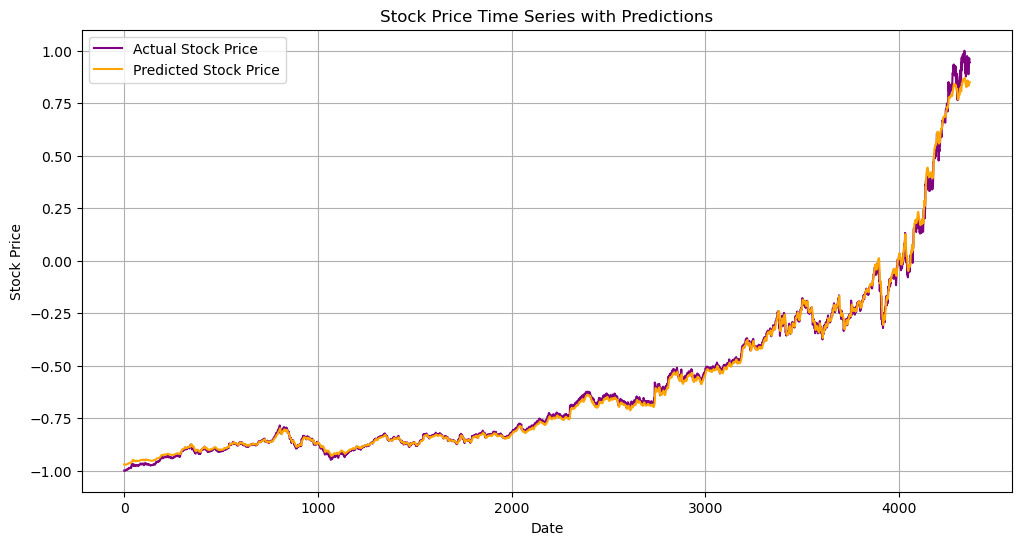

In [164]:
with torch.no_grad():
	predicted = model(X_train.to(device)).to('cpu').numpy()
	
# plot the original data
plt.figure(figsize=[12, 6])
plt.plot(y_train, label='Actual Stock Price', color='purple')
plt.plot(predicted, label='Predicted Stock Price', color='orange')
plt.title('Stock Price Time Series with Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()